In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [4]:
local_zip = '/content/drive/MyDrive/data_folder.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data_folder')
zip_ref.close()

base_dir = '/content/data_folder'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode = 'binary', target_size = (224, 224))
validation_generator = validation_datagen.flow_from_directory(validation_dir,  batch_size = 32, class_mode = 'binary', target_size = (224, 224), shuffle = False)
test_generator = test_datagen.flow_from_directory(test_dir,  batch_size = 32, class_mode = 'binary', target_size = (224, 224), shuffle = False)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [7]:
es = EarlyStopping(monitor='val_acc', patience=5,start_from_epoch=15, restore_best_weights=True)

In [8]:
base_model_list={'base_vgg19': VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False),
            'base_inception_v3': InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False),
            'base_xception': Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False),
}
for model in base_model_list.values():
  for layer in model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# VGG19
x2 = layers.Flatten()(base_model_list['base_vgg19'].output)
x2 = layers.Dense(512, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)
x2 = layers.Dense(1, activation='sigmoid')(x2)
vgg19_finetuned = models.Model(base_model_list['base_vgg19'].input, x2)

vgg19_finetuned.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
#InceptionV3
x3 = layers.Flatten()(base_model_list['base_inception_v3'].output)
x3 = layers.Dense(1024, activation='relu')(x3)
x3 = layers.Dropout(0.2)(x3)
x3 = layers.Dense(1, activation='sigmoid')(x3)

inception_v3_finetuned = models.Model(base_model_list['base_inception_v3'].input, x3)

inception_v3_finetuned.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
#Xception
x4 = layers.GlobalAveragePooling2D()(base_model_list['base_xception'].output)
x4 = layers.Dropout(0.5)(x4)
x4 = layers.Dense(1, activation='sigmoid')(x4)
xception_finetuned = models.Model(base_model_list['base_xception'].input, x4)

xception_finetuned.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
# VGG19 finetuned
vgg_his = vgg19_finetuned.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=200,
    batch_size=256,
    validation_data=validation_generator,
    callbacks=[es]
)
vgg19_finetuned.save('/content/drive/MyDrive/vgg_model.h5')
with open('/content/drive/MyDrive/vgg_his.pkl', 'wb') as file:
    pickle.dump(vgg_his.history, file)

Epoch 1/20
200/200 [==============================] - 118s 539ms/step - loss: 0.3962 - acc: 0.8145 - val_loss: 0.2357 - val_acc: 0.8980
Epoch 2/20
200/200 [==============================] - 102s 507ms/step - loss: 0.2753 - acc: 0.8777 - val_loss: 0.2180 - val_acc: 0.9104
Epoch 3/20
200/200 [==============================] - 102s 511ms/step - loss: 0.2396 - acc: 0.8992 - val_loss: 0.2099 - val_acc: 0.9096
Epoch 4/20
200/200 [==============================] - 109s 547ms/step - loss: 0.2322 - acc: 0.8986 - val_loss: 0.2239 - val_acc: 0.9056
Epoch 5/20
200/200 [==============================] - 102s 509ms/step - loss: 0.2405 - acc: 0.8964 - val_loss: 0.2182 - val_acc: 0.9056
Epoch 6/20
200/200 [==============================] - 103s 514ms/step - loss: 0.2304 - acc: 0.9027 - val_loss: 0.1893 - val_acc: 0.9168
Epoch 7/20
200/200 [==============================] - 101s 507ms/step - loss: 0.2285 - acc: 0.9009 - val_loss: 0.2214 - val_acc: 0.9036
Epoch 8/20
200/200 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# InceptionV3 finetuned
inception_his = inception_v3_finetuned.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=200,
    batch_size=256,
    validation_data=validation_generator,
    callbacks=[es]
)
inception_v3_finetuned.save('/content/drive/MyDrive/inception_model.h5')
with open('/content/drive/MyDrive/inception_his.pkl', 'wb') as file:
    pickle.dump(inception_his.history, file)

Epoch 1/20
200/200 [==============================] - 105s 482ms/step - loss: 0.2061 - acc: 0.9639 - val_loss: 0.0722 - val_acc: 0.9852
Epoch 2/20
200/200 [==============================] - 95s 476ms/step - loss: 0.0995 - acc: 0.9789 - val_loss: 0.0700 - val_acc: 0.9852
Epoch 3/20
200/200 [==============================] - 91s 454ms/step - loss: 0.0911 - acc: 0.9795 - val_loss: 0.0547 - val_acc: 0.9860
Epoch 4/20
200/200 [==============================] - 92s 458ms/step - loss: 0.0772 - acc: 0.9806 - val_loss: 0.0476 - val_acc: 0.9836
Epoch 5/20
200/200 [==============================] - 95s 473ms/step - loss: 0.0465 - acc: 0.9845 - val_loss: 0.1767 - val_acc: 0.9548
Epoch 6/20
200/200 [==============================] - 90s 450ms/step - loss: 0.0687 - acc: 0.9811 - val_loss: 0.0402 - val_acc: 0.9868
Epoch 7/20
200/200 [==============================] - 91s 455ms/step - loss: 0.0473 - acc: 0.9844 - val_loss: 0.0532 - val_acc: 0.9856
Epoch 8/20
200/200 [==============================] - 

In [ ]:
# Xception finetuned
xception_his = xception_finetuned.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=200,
    batch_size=256,
    validation_data=validation_generator,
    callbacks=[es]
)
xception_finetuned.save('/content/drive/MyDrive/xception_model.h5')
with open('/content/drive/MyDrive/xception_his.pkl', 'wb') as file:
    pickle.dump(xception_his.history, file)

Epoch 1/20
200/200 [==============================] - 107s 494ms/step - loss: 0.4615 - acc: 0.8117 - val_loss: 0.2496 - val_acc: 0.9720
Epoch 2/20
200/200 [==============================] - 96s 478ms/step - loss: 0.2176 - acc: 0.9605 - val_loss: 0.1454 - val_acc: 0.9788
Epoch 3/20
200/200 [==============================] - 96s 479ms/step - loss: 0.1482 - acc: 0.9681 - val_loss: 0.1071 - val_acc: 0.9808
Epoch 4/20
200/200 [==============================] - 96s 481ms/step - loss: 0.1133 - acc: 0.9748 - val_loss: 0.0874 - val_acc: 0.9824
Epoch 5/20
200/200 [==============================] - 96s 481ms/step - loss: 0.0962 - acc: 0.9766 - val_loss: 0.0760 - val_acc: 0.9824
Epoch 6/20
200/200 [==============================] - 96s 479ms/step - loss: 0.0871 - acc: 0.9777 - val_loss: 0.0687 - val_acc: 0.9832
Epoch 7/20
200/200 [==============================] - 97s 485ms/step - loss: 0.0778 - acc: 0.9787 - val_loss: 0.0638 - val_acc: 0.9832
Epoch 8/20
200/200 [==============================] - 

In [ ]:
with open('/content/drive/MyDrive/vgg_his.pkl', 'rb') as file:
  vgg_his = pickle.load(file)
with open('/content/drive/MyDrive/inception_his.pkl', 'rb') as file:
  inception_his = pickle.load(file)
with open('/content/drive/MyDrive/xception_his.pkl', 'rb') as file:
  xception_his = pickle.load(file)
histories ={
            'VGG19': vgg_his,
            'InceptionV3': inception_his,
            'Xception': xception_his
}

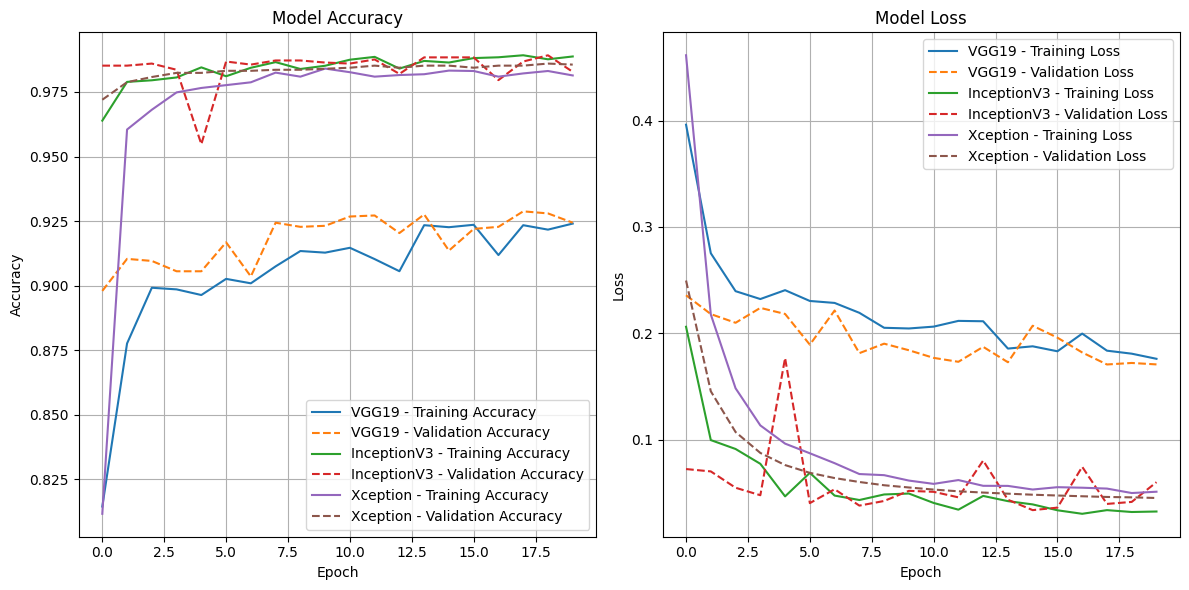

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for model_name, history in histories.items():
    plt.plot(history['acc'], label=f'{model_name} - Training Accuracy', linestyle='-')
    plt.plot(history['val_acc'], label=f'{model_name} - Validation Accuracy', linestyle='--')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'{model_name} - Training Loss', linestyle='-')
    plt.plot(history['val_loss'], label=f'{model_name} - Validation Loss', linestyle='--')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
inception = load_model('/content/drive/MyDrive/inception_model.h5')
vgg19 = load_model('/content/drive/MyDrive/vgg_model.h5')
xception = load_model('/content/drive/MyDrive/xception_model.h5')

In [10]:
models = {
    'InceptionV3': inception,
    'VGG19': vgg19,
    'Xception': xception
}

In [11]:
for model in models.values():
  model.evaluate(test_generator)

79/79 [==============================] - 17s 152ms/step - loss: 0.0414 - acc: 0.9864


79/79 [==============================] - 11s 133ms/step


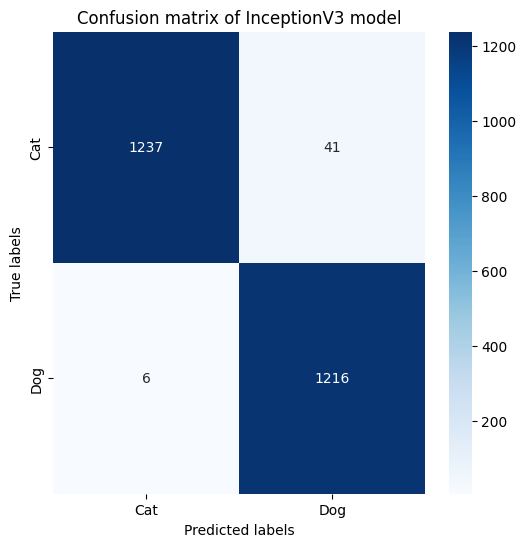

79/79 [==============================] - 13s 164ms/step


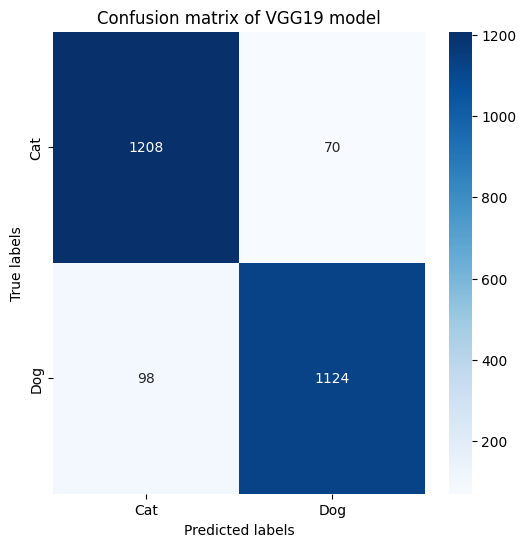

79/79 [==============================] - 12s 153ms/step


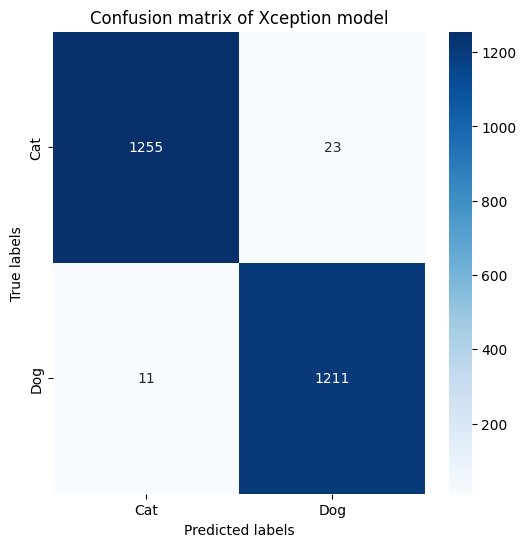

In [14]:
for name, estimator in models.items():
  predictions = estimator.predict(test_generator).flatten()
  y_pred = (predictions > 0.5).astype(int)
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(f'Confusion matrix of {name} model')
  plt.show()

In [13]:
for name, estimator in models.items():
  predictions = estimator.predict(test_generator).flatten()
  y_pred = (predictions > 0.5).astype(int)
  print(f'Classification report of {name} model:')
  print(classification_report(test_generator.classes, y_pred, target_names=['Cat', 'Dog']))

79/79 [==============================] - 6s 78ms/step
Classification report of InceptionV3 model:
              precision    recall  f1-score   support

         Cat       1.00      0.97      0.98      1278
         Dog       0.97      1.00      0.98      1222

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500

79/79 [==============================] - 13s 168ms/step
Classification report of VGG19 model:
              precision    recall  f1-score   support

         Cat       0.92      0.95      0.93      1278
         Dog       0.94      0.92      0.93      1222

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500

79/79 [==============================] - 12s 155ms/step
Classification report of Xception model:
              precision    recall  f1-score   support

  